In [1]:
from collections import Counter
import json
import os
import pandas
import numpy
import re
import requests
import matplotlib.pyplot as plt
from watson_developer_cloud import DiscoveryV1

%matplotlib inline

## 1. Setup

Here, we are just setting up the credentials for our WDS service. Note that the version is the most recent version as of the creation of this notebook (5/10/18).

In [2]:
# CREDENTIALS FOR THE DISCOVERY-WEXP INSTANCE

my_credentials = {
  "url": "https://gateway.watsonplatform.net/discovery/api",
  "username": "REDACTED"
  "password": "REDACTED"
}

In [4]:
discovery = DiscoveryV1(
  username=my_credentials["username"],
  password=my_credentials["password"],
  version="2018-03-05"
  #version="2017-11-07"
)


For all entity types, see https://console.bluemix.net/docs/services/natural-language-understanding/entity-types.html#entity-types-and-subtypes

For the category hierarchym see https://console.bluemix.net/docs/services/natural-language-understanding/categories.html#categories-hierarchy

For the relation types, see https://console.bluemix.net/docs/services/natural-language-understanding/relations-v1.html#relation-types-version-1-

## 2. 

## Experiment: Steel and Aluminum (Tariffs, etc)

These queries were inspired by the question of what we can learn in the news about steel and aluminum (and wheter we can surface any insight about potential tariffs). At this point, much of the news about tariffs has moved on, but the queries themselves are still worth looking at.

A couple things to note about the query:

+ It sometimes helps to look into "enriched title" rather than "enriched text", if you're getting more irrelevant results. That way, we'll only return articles that have the name of the commodity in the title; we might miss out on some articles that mention that commodity in passing, but this generally seems to be a tradeoff worth making for pretty common commodities
+ Note that we've used the single colon ':', rather than the double '::'. The single colon means 'includes' (and is case insensitive). There may be times you want an exact match, however, since a commodity name may be a part of some other word (like Ore and Oregon).
+ The aggregation terms here are set up because we don't just want to look at some news articles, but we want to look at facilities; facility is an entity type that Watson recognizes. What the aggregation query below is saying is: Give me the entities that are filtered so that their type is an exact match of "Facility"; give me the name of that entity, up to thirty results.

See https://console.bluemix.net/docs/services/discovery/query-reference.html#query-reference

Some further thoughts about queries:

+ Some commodoties will have too many results, many of which are irrelevant. To improve precision, you can narrow down what you're getting back by looking at the title of the article rather than its body, and by further filtering the results by some restricting the concept of the article (further down the page, there's an example where we filter by concept "industry".

+ Some commodities will have too few results. To improve recall, broaden the search: look in the article body, and if necessary, simply search for the word or phrase itself rather than looking through enriched_text (these searches are used toward the bottom of this document).

+ You can also consider adding a filter to your search for words like "futures", "market", or "index" if you want to only find articles that refer to financial markets with respect to that commodity.

In [14]:
qopts = {}
qopts["query"] = 'enriched_title.entities.text:"steel"'
qopts["aggregation"] = '[nested(enriched_text.entities).filter(enriched_text.entities.type::"Facility").term(enriched_text.entities.text,count:30)]'
results = discovery.query('system', 'news', **qopts)

for line in results['aggregations'][0]['aggregations'][0]['aggregations'][0]['results']:
    print ("Facility: {:50} Results: {}".format(line['key'], line['matching_results']))  

Facility: Liberty House                                      Results: 53
Facility: Burns Waterway                                     Results: 33
Facility: White House                                        Results: 32
Facility: Ajaokuta Steel Complex                             Results: 21
Facility: Bethlehem Steel FC                                 Results: 16
Facility: Cintas Center                                      Results: 16
Facility: Fort Wayne                                         Results: 15
Facility: Indiana Dunes National Lakeshore                   Results: 14
Facility: Fort McCoy                                         Results: 13
Facility: Goodman Stadium                                    Results: 12
Facility: Coachella Valley Music & Arts Festival             Results: 11
Facility: Trump Tower                                        Results: 10
Facility: EL Ezz Aldekhela Steel                             Results: 9
Facility: Pennsylvania Convention Center            

### As an aside: if you don't want to use the Python API, you don't have to. You can send your query as a get request, like this:

In [15]:
r = requests.get('https://gateway.watsonplatform.net/discovery/api/v1/environments/system/collections/news-en/query?version=2017-11-07&aggregation=nested%28enriched_text.entities%29.filter%28enriched_text.entities.disambiguation.subtype%3A%22Person%22%29.term%28enriched_text.entities.text%2Ccount%3A10%29&deduplicate=false&highlight=true&passages=true&passages.count=5&query=enriched_text.entities.text%3A%22IBM%22', auth=('19787ef7-8ecd-4ad0-aa57-b3a31ace11d4', 'AQ0Ncx8QQkic'))

In [24]:
r_json = json.loads(r.content)
r_json['aggregations'][0]['aggregations'][0]['aggregations'][0]['results']

[{'key': 'Deutsche Bank', 'matching_results': 48},
 {'key': 'PBS', 'matching_results': 20},
 {'key': 'Deutsche Bank AG', 'matching_results': 18},
 {'key': 'Deere & Company', 'matching_results': 17},
 {'key': 'FIFA', 'matching_results': 15},
 {'key': 'GGV Capital', 'matching_results': 13},
 {'key': 'Louis Vuitton', 'matching_results': 13},
 {'key': 'Deere & Co.', 'matching_results': 6},
 {'key': 'Warner Bros', 'matching_results': 6},
 {'key': 'Allen Institute for Artificial Intelligence', 'matching_results': 5}]

In the next query, we want to find the companies in the news about steel.

Note that the search is the same -- we're still looking for 'steel' as contained in the title.
The aggregation is similar -- our filter on entities is now for type "Company", but everything else is the same.

In [28]:
qopts = {}
qopts["query"] = 'enriched_title.entities.text:"steel"'
qopts["aggregation"] = '[nested(enriched_text.entities).filter(enriched_text.entities.type::"Company").term(enriched_text.entities.text,count:30)]'
results = discovery.query('system', 'news', **qopts)

for line in results['aggregations'][0]['aggregations'][0]['aggregations'][0]['results']:
    print ("Company: {:50} Results: {}".format(line['key'], line['matching_results']))

Company: NYSE                                               Results: 801
Company: Tata Steel                                         Results: 575
Company: ArcelorMittal                                      Results: 549
Company: Reuters                                            Results: 513
Company: Essar Steel                                        Results: 483
Company: MarketBeat.com                                     Results: 465
Company: Zacks Investment Research                          Results: 381
Company: Goldman Sachs                                      Results: 372
Company: JSW Steel                                          Results: 321
Company: Bank of America                                    Results: 305
Company: ValuEngine                                         Results: 297
Company: Numetal                                            Results: 288
Company: AK Steel Holding Corporation                       Results: 269
Company: Schnitzer Steel Industries                

Now, we're looking for locations in the news.

The query is the same, except we're now filtering entities for type "Location."

In [31]:
qopts = {}
qopts["query"] = 'enriched_title.entities.text:"steel"'
qopts["aggregation"] = '[nested(enriched_text.entities).filter(enriched_text.entities.type::"Location").term(enriched_text.entities.text,count:30)]'
results = discovery.query('system', 'news', **qopts)

for line in results['aggregations'][0]['aggregations'][0]['aggregations'][0]['results']:
    print ("Location: {:30} Results: {}".format(line['key'], line['matching_results']))

Location: United States                  Results: 995
Location: India                          Results: 634
Location: Europe                         Results: 576
Location: US                             Results: 562
Location: North America                  Results: 552
Location: China                          Results: 469
Location: U.S.                           Results: 461
Location: Canada                         Results: 347
Location: Japan                          Results: 342
Location: Mexico                         Results: 330
Location: Ohio                           Results: 310
Location: Russia                         Results: 290
Location: Indiana                        Results: 238
Location: Pennsylvania                   Results: 220
Location: Australia                      Results: 206
Location: Ahmedabad                      Results: 181
Location: California                     Results: 153
Location: Mumbai                         Results: 145
Location: UK                

## Drill down from that query to find news about some particular region...

The next search is getting a bit more specific: We are searching the title of the article for 'steel' and the text of the article for 'canada' to do a search about news in Canada.

We also have an aggregation to look at locations which we can look at as well.

Also note that, in addition, we are limiting to 30 results, and we are de-duplicating results. 

In [35]:
qopts = {}
qopts["query"] = 'enriched_title.entities.text:"Steel",enriched_text.entities.text:"canada"'
qopts["aggregation"] = '[nested(enriched_text.entities).filter(enriched_text.entities.type::"Location").term(enriched_text.entities.text,count:30)]'
qopts["count"] = 30
qopts["deduplicate"] = True

results = discovery.query('system', 'news', **qopts)


In [36]:
for result in results['results']:
    print (result['title'], result['url'])

Steel News http://www.aist.org/news/steel-news/2018/may-(1)/6-11-may-2018/arcelormittal-dofasco-plans-hot-mill-upgrades
Trudeau Steel http://news.naver.com/main/read.nhn?oid=077&aid=0004071877
To boldly go: Italgem Steel takes jewellery where no man has gone before https://www.jewellerybusiness.com/features/to-boldly-go-italgem-steel-takes-jewellery-where-no-man-has-gone-before/
Reps block concession of Ajaokuta Steel http://nigeria.shafaqna.com/EN/NG/5276374
New Head Of Scandal-Hit Kobe Steel May Seek Mergers For Some Business Units https://www.longroom.com/discussion/934667/new-head-of-scandal-hit-kobe-steel-may-seek-mergers-for-some-business-units
Canada Steel http://news.naver.com/main/read.nhn?oid=077&aid=0004072128
Why tariffs on steel and aluminium are easier said than done - Steel banned https://www.economist.com/news/finance-and-economics/21739164-history-offers-some-tough-lessons-why-tariffs-steel-and-aluminium-are-easier?fsrc=rss
Federal and provincial governments support ne

Let's look at the locations that show up in this search...

In [40]:
results['aggregations'][0]['aggregations'][0]['aggregations'][0]

{'count': 30,
 'field': 'enriched_text.entities.text',
 'results': [{'key': 'Canada', 'matching_results': 353},
  {'key': 'United States', 'matching_results': 245},
  {'key': 'Mexico', 'matching_results': 197},
  {'key': 'North America', 'matching_results': 175},
  {'key': 'China', 'matching_results': 138},
  {'key': 'Australia', 'matching_results': 122},
  {'key': 'Europe', 'matching_results': 105},
  {'key': 'France', 'matching_results': 99},
  {'key': 'South Korea', 'matching_results': 85},
  {'key': 'Japan', 'matching_results': 76},
  {'key': 'South America', 'matching_results': 70},
  {'key': 'Turkey', 'matching_results': 64},
  {'key': 'Brazil', 'matching_results': 63},
  {'key': 'U.S.', 'matching_results': 60},
  {'key': 'Malaysia', 'matching_results': 56},
  {'key': 'Belgium', 'matching_results': 53},
  {'key': 'Germany', 'matching_results': 52},
  {'key': 'United Kingdom', 'matching_results': 52},
  {'key': 'India', 'matching_results': 51},
  {'key': 'Oregon', 'matching_result

## What are the sentiment results by country?

We also get sentiment results from the news; we can drill down and get particular sentiment scores.

We have still have the same query for steel, and we're looking at an aggregation that pulls together entities of type 'location', and looking at the average sentiment score for those results by location.

In [56]:
qopts = {}
qopts["query"] = 'enriched_title.entities.text:"steel"'
qopts["aggregation"] = 'nested(enriched_text.entities).filter(enriched_text.entities.type::"Location").term(enriched_text.entities.text,count:10).average(enriched_text.entities.sentiment.score)'
qopts["count"] = 50
qopts["deduplicate"] = True
results = discovery.query('system', 'news', **qopts)


In [59]:
for r in results['aggregations'][0]['aggregations'][0]['aggregations'][0]['results']:
    print ("{:30}:{}".format(r['key'], r['aggregations'][0]['value']))

United States                 :-0.12164606495983935
India                         :0.009387370300157974
Europe                        :0.014634436933797915
US                            :-0.1527344951612903
North America                 :0.05528536813186816
China                         :0.12378767221006566
U.S.                          :-0.20023959686098655
Canada                        :-0.03822385495495495
Japan                         :-0.0650687983974359
Mexico                        :-0.01869098263665595


## Run through some countries and get some summary stats

In [66]:
qopts = {}
qopts["query"] = 'enriched_title.entities.text:"steel"'
qopts["aggregation"] = '[nested(enriched_text.entities).filter(enriched_text.entities.type::"Location").term(enriched_text.entities.text,count:15)]'
results = discovery.query('system', 'news', **qopts)

countries = []
for line in results['aggregations'][0]['aggregations'][0]['aggregations'][0]['results']:
    countries.append(line['key'])

In [68]:
for c in countries:
    print ("{}:".format(c))
    query = 'enriched_title.entities.text:"steel", enriched_text.entities.text:"{}"'.format(c)
    agg = 'nested(enriched_text.entities).filter(enriched_text.entities.type::"Company").term(enriched_text.entities.text,count:10)'
    qopts["query"] = query
    qopts["aggregation"] = agg
    results = discovery.query('system', 'news', **qopts)
    for line in results['aggregations'][0]['aggregations'][0]['aggregations'][0]['results']:
        print ("Company: {:50} Results: {}".format(line['key'], line['matching_results']))
    print ("**")

United States:
Company: NYSE                                               Results: 506
Company: MarketBeat.com                                     Results: 292
Company: United States Steel Corporation                    Results: 240
Company: Bank of America                                    Results: 225
Company: Zacks Investment Research                          Results: 193
Company: Goldman Sachs                                      Results: 185
Company: Reliance Steel                                     Results: 184
Company: Reliance Steel & Aluminum                          Results: 167
Company: Longbow Research                                   Results: 163
Company: AK Steel Holding Corporation                       Results: 150
**
India:
Company: ArcelorMittal                                      Results: 354
Company: Essar Steel                                        Results: 319
Company: Tata Steel                                         Results: 319
Company: JSW Steel        

Company: AK Steel Holding Corporation                       Results: 118
Company: NYSE                                               Results: 113
Company: AK Steel Holding Co.                               Results: 71
Company: AK Steel Company                                   Results: 62
Company: Jefferies Group                                    Results: 59
Company: Zacks Investment Research                          Results: 58
Company: MarketBeat.com                                     Results: 44
Company: Longbow Research                                   Results: 42
Company: Goldman Sachs                                      Results: 35
Company: Crow Point Partners LLC                            Results: 33
**
Pennsylvania:
Company: AK Steel Holding Corporation                       Results: 166
Company: NYSE                                               Results: 142
Company: AK Steel Company                                   Results: 79
Company: MarketBeat.com                    

## Discovering that tariffs are happening?

The original purpose of this query was to see what concepts show up in articles about steel, and see if we can learn about tarrifs. By now, tarrifs have fallen out of the news somewhat, but they still show up among the top results.

Note also that we have changed the query slightly to better focus on articles about steel: we are now looking at articles that get categorized by 'industry,' so as to remove some irrelevant results.

In [73]:
qopts = {}
qopts["query"] = 'enriched_text.entities.text:"steel",enriched_text.categories.label:"industry"'
qopts["aggregation"] = 'term(enriched_text.concepts.text,count:10)'
results = discovery.query('system', 'news', **qopts)

In [74]:
results['aggregations'][0]['results']

[{'key': 'Steel', 'matching_results': 5577},
 {'key': 'Stock', 'matching_results': 3661},
 {'key': 'Stock market', 'matching_results': 3378},
 {'key': 'United States', 'matching_results': 3357},
 {'key': 'International trade', 'matching_results': 2724},
 {'key': 'Iron', 'matching_results': 2241},
 {'key': 'Donald Trump', 'matching_results': 2130},
 {'key': 'Tariff', 'matching_results': 1542},
 {'key': 'Economics', 'matching_results': 1476},
 {'key': 'Financial ratio', 'matching_results': 1376}]

## Searching news by producers of aluminum

Now, we search by company and display the top result and its URL.

In [78]:
companies = [
    "Rusal",
    "Rio Tinto Alcan",
    "Hongqiao"
]

#Note: Rusal in Russian, RTA is Canadian, and Hongqiao is Chinese; these are the three largest alumnimun manufactors

qopts = {}
qopts["deduplicate"] = True
for c in companies:
    qopts["query"] = 'title:{}'.format(c)
    results = discovery.query('system', 'news', **qopts)
    print (results['results'][0]['title'], results['results'][0]['url'])



United Rusal : Rusal applies GDS delisting from Euronext Paris http://www.4-traders.com/UNITED-COMPANY-RUSAL-PLC-6165909/news/United-Rusal-Rusal-applies-GDS-delisting-from-Euronext-Paris-26295130/
Rio Tinto Alcan fined for violating Fisheries Act https://steelguru.com/steel/Rio%20Tinto%20Alcan%20fined%20for%20violating%20Fisheries%20Act/508693?type=steel
China Hongqiao Group Ltd http://www.4-traders.com/CHINA-HONGQIAO-GROUP-LTD-7650006/news/China-Hongqiao-Group-Ltd-annual-earnings-release-26196645/


## WDS Anomaly Detection

Here, we're looking for anomalies in the news: on what days do we have way more articles than usual? We'll run the query, then plot the results.

I've run this example with soybeans, which were in the news more recently (and thus more likely to have anomalous days). We'll print out what days the anomalies occur, and a sample news story from that day, then plot the time series of number of articles.

For the query: note that we're just doing a simple search for the text 'soybeans'. We're filtering by English. Our aggregation is for a timeslice, which we're selecting by date of article crawled, with a one day window (as defined by the Eastern time zone), also pulling the top keyword and title from that day.

In [85]:
# Anomaly detection query

q = {
  "query": "\"Soybeans\"",
  "filter": "language:(english|en)",
  "count": 15,
  "aggregation":"timeslice(field:crawl_date,interval:1day,time_zone:America/New_York,anomaly:true).term(enriched_text.keywords.text,count:1).term(title,count:1)",
  "deduplicate": True
}

results = discovery.query('system', 'news', **q)

In [95]:
r

{'aggregations': [{'count': 1,
   'field': 'enriched_text.keywords.text',
   'results': [{'aggregations': [{'count': 1,
       'field': 'title',
       'results': [{'key': 'Planting of corn and soybeans underway in South Dakota',
         'matching_results': 4}],
       'type': 'term'}],
     'key': 'soybeans',
     'matching_results': 45}],
   'type': 'term'}],
 'key': 1525924800000,
 'key_as_string': '2018-05-10T00:00:00.000-04:00',
 'matching_results': 373}

In [104]:
res_counts = []
res_ohv = []
for r in results['aggregations'][0]['results']:
    res_counts.append(r['matching_results'])
    if 'anomaly' in r.keys():
        print ('Anomaly detected!')
        print (r['key_as_string'], r['aggregations'][0]['results'][0]['aggregations'][0]['results'][0]['key'])
        print ("Top Keyword: {}\n".format(r['aggregations'][0]['results'][0]['key']))
        res_ohv.append(1)
    else:
        res_ohv.append(0)

Anomaly detected!
2018-04-04T00:00:00.000-04:00 On the brink: US and China threaten tariffs as fears rise
Top Keyword: China

Anomaly detected!
2018-04-05T00:00:00.000-04:00 Trump proposes $100 billion in new tariffs on Chinese goods
Top Keyword: China

Anomaly detected!
2018-04-06T00:00:00.000-04:00 China vows to 'counterattack' US as trade spat worsens
Top Keyword: President Donald Trump



In [105]:
span = len(results['aggregations'][0]['results'])
dates = [results['aggregations'][0]['results'][i]['key_as_string'] for i in range(span)]
dates = [d[:10] for d in dates]

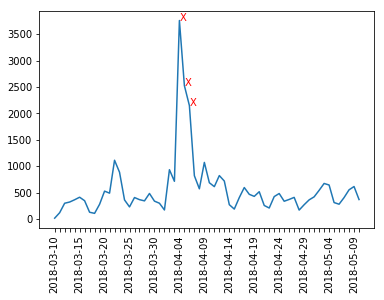

In [106]:
#labels = dates[::5]
labels = [d if i % 5 == 0 else ' ' for i, d in enumerate(dates)]
plt.plot(range(len(res_counts)), res_counts)
plt.xticks(range(len(labels)), labels, rotation='vertical')

for i, y in enumerate(res_counts):
    if res_ohv[i] == 1:
        plt.annotate('X', xy=(i, y), color='r')

plt.show()

### Co-Mentions and Trends

These queries look at particular commodities (aluminum and soybeans) and see top keywords in the news about that, as well as the sentiment of those articles by keyword.

The third query looks at a company that has been in the news about its bankrupcy. Note that we've located bankrupcy as one of the keywords, and that these articles have particularly low sentiment scores.

In [109]:
q = {
  "query": "\"Aluminum\"",
  "filter": "language:(english|en)",
  "aggregation": [
      "term(enriched_text.keywords.text,count:10).average(enriched_title.sentiment.document.score)"
  ]
}

results = discovery.query('system', 'news', **q)

In [110]:
for rez in results['aggregations'][0]['results']:
    print ("{:50}  Number of articles: {}  Sentiment: {}".format(
        rez['key'], rez['matching_results'], rez['aggregations'][0]['value']))

President Donald Trump                              Number of articles: 30414  Sentiment: -0.16424030938052808
United States                                       Number of articles: 20920  Sentiment: -0.15871410416170567
Trump administration                                Number of articles: 15635  Sentiment: -0.20012140003198153
trade war                                           Number of articles: 12703  Sentiment: -0.25771839318271283
China                                               Number of articles: 12178  Sentiment: -0.2160805773129671
White House                                         Number of articles: 11961  Sentiment: -0.14012109956438126
tariffs                                             Number of articles: 11248  Sentiment: -0.22056191062066516
aluminum tariffs                                    Number of articles: 9466  Sentiment: -0.125321118945589
President Trump                                     Number of articles: 8886  Sentiment: -0.1548327626585682
percent

In [111]:
q = {
  "query": "\"Soybeans\"",
  "filter": "language:(english|en)",
  "aggregation": [
      "term(enriched_text.keywords.text,count:10).average(enriched_title.sentiment.document.score)"
  ]
}

results = discovery.query('system', 'news', **q)
for rez in results['aggregations'][0]['results']:
    print ("{:50}  Number of articles: {}  Sentiment: {}".format(
        rez['key'], rez['matching_results'], rez['aggregations'][0]['value']))

China                                               Number of articles: 11844  Sentiment: -0.2669338540488051
President Donald Trump                              Number of articles: 10918  Sentiment: -0.26500722222934603
trade war                                           Number of articles: 9823  Sentiment: -0.2986796142231724
United States                                       Number of articles: 9305  Sentiment: -0.27245810051585173
Trump administration                                Number of articles: 7169  Sentiment: -0.2797062634626117
tariffs                                             Number of articles: 5957  Sentiment: -0.2835373509905978
Chinese goods                                       Number of articles: 4898  Sentiment: -0.2802585068803594
soybeans                                            Number of articles: 4884  Sentiment: -0.19498681085176087
World Trade Organization                            Number of articles: 3357  Sentiment: -0.2867162021745607
White House   

In [114]:
q = {
  "query": "\"Toys R Us\"",
  "filter": "language:(english|en)",
  "aggregation": [
      "term(enriched_text.concepts.text,count:10).average(enriched_title.sentiment.document.score)"
  ]
}

results = discovery.query('system', 'news', **q)
for rez in results['aggregations'][0]['results']:
    print ("{:50}  Number of articles: {}  Sentiment: {}".format(
        rez['key'], rez['matching_results'], rez['aggregations'][0]['value']))

Toy                                                 Number of articles: 4424  Sentiment: -0.24132985595749482
Retailing                                           Number of articles: 4207  Sentiment: -0.2424886766048501
Bankruptcy                                          Number of articles: 3789  Sentiment: -0.2753180539070748
Mattel                                              Number of articles: 3195  Sentiment: -0.2754573921102067
Toys "R" Us                                         Number of articles: 3171  Sentiment: -0.21767586441640377
Toy dog                                             Number of articles: 2926  Sentiment: -0.27169817900854704
Wal-Mart                                            Number of articles: 2910  Sentiment: -0.2702188721897558
Liquidation                                         Number of articles: 2498  Sentiment: -0.26754845006007194
United States                                       Number of articles: 2459  Sentiment: -0.19503345957706378
Sales         